In [1]:
import numpy as np
import kwant
from matplotlib import pyplot
import math
from pylab import meshgrid
import scipy.linalg as la
from scipy.constants import physical_constants
from scipy.integrate import quad
import scipy.sparse.linalg as sla
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


h_bar = physical_constants['Planck constant over 2 pi'][0]
hh = physical_constants['Planck constant'][0]
m_el = physical_constants['electron mass'][0]
eV_unit = physical_constants['electron volt'][0]
el_charge = physical_constants['elementary charge'][0]
k_B = physical_constants['Boltzmann constant'][0]
m_ef=0.067*m_el
hbrar_meV=h_bar*1000/el_charge


a_unit=10**(-9) #nm to m
t_unit_J=h_bar**(2)/(2*m_ef*a_unit**2)
t_unit_eV = t_unit_J/eV_unit

In [2]:
t=1
# a unit -> 1nm in meters
N=100 #number of steps in lattice
L=200 #200 nm
a=L/N


 
    
    
r_0=L
r_B=0.5*r_0
V_QR=0
V_1=1
V_0=0.5

In [3]:
def V(x,y,V_QD):
        r=(x**2+y**2)**(0.5)
        if r<r_B:
            return V_QD+(V_0-V_QD)*math.exp(-0.18/N*(r-r_B)**(2*p))
        else:
            return V_1*(1-math.exp(-(r/r_0)**30))+V_0*math.exp(-0.18/N*(r-r_B)**(2*p))
        
def onsite(site,V_QD):
        (x,y)=site.pos
        return 4*t+V(x,y,V_QD)
    
    
def plot_V(site,V_QD):
        (x,y)=site.pos
        return V(x,y,V_QD)

def make_system(a=a, t=t):
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity).

    lat = kwant.lattice.square(a, norbs=1)

    syst = kwant.Builder()

    # Define the quantum dot
    def circle(pos):
        (x, y) = pos
        rsq = x ** 2 + y ** 2
        return rsq < r_0 ** 2

    
    syst[lat.shape(circle, (0, 0))] = onsite
    # hoppings in x-direction
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t
    # hoppings in y-directions
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = -t

    # It's a closed system for a change, so no leads
    return syst

In [4]:

sys=make_system()

In [5]:
#sys[(lat(i,j) for i in range(-L-1,L+1) for j in range(-L-1,L+1) if (i**2+j**2)<(r_0**2) )]=onsite

#sys[lat.neighbors()]=-t #hopping

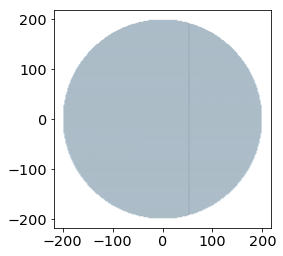

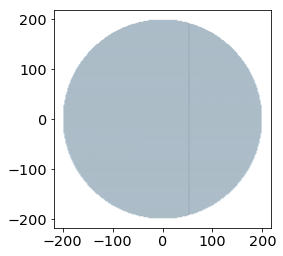

In [6]:
kwant.plot(sys)

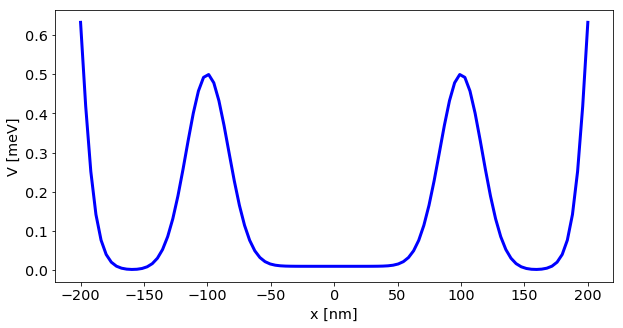

In [7]:
fig = pyplot.figure(figsize=(10, 5))
pyplot.xlabel("x [nm]")
pyplot.ylabel("V [meV]")
#pyplot.rc('font', family='serif', size=8)
p=1
V_qd=0.01
X=np.linspace(-L,L,100)
V_x=[V(x,0,V_qd) for x in X]
#print(X)
#print(V_x)
pyplot.plot(X,V_x,linewidth=3.0,color='b')
fig.savefig('../plot/Vx.eps')

/home/michal/anaconda2/envs/acmin/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: The plotted data contains 0.62% of values overflowing upper limit 0.610151 
  """Entry point for launching an IPython kernel.


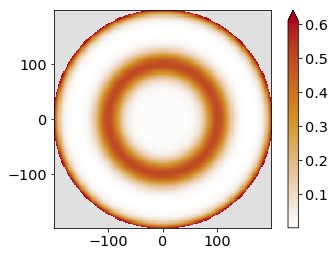

In [8]:
kwant.plotter.map(sys, lambda s: plot_V(s,V_qd), file="../plot/Vxy.eps")


In [9]:
sysf = sys.finalized()

#ham_mat = sysf.hamiltonian_submatrix(params=dict(V_QD=0.1), sparse=True)

#En = sla.eigsh(ham_mat.tocsc(), k=15, sigma=0, return_eigenvectors=False)
#Ev = sla.eigsh(ham_mat.tocsc(), k=15, sigma=0, return_eigenvectors=True)
#print(En)
#print(Ev)

In [11]:
def sorted_eigs(ev):
    evals, evecs = ev
    evals, evecs = map(np.array, zip(*sorted(zip(evals, evecs.transpose()))))
    evals=evals*t_unit_eV*1000
    return evals, evecs.transpose()

In [48]:
from ipywidgets import interact

def plot_eigenstates(V_qd, n,file=False):
    # Calculate the wave functions in the system.
    ham_mat = sysf.hamiltonian_submatrix(sparse=True, params=dict(V_QD=V_qd))
    evals, evecs = sorted_eigs(sla.eigsh(ham_mat.tocsc(), k=45, sigma=0))
    file_name='../plot/eigenstates/'+str(V_qd)+'/f'+str(n)+'.eps'
    if file:
            kwant.plotter.density(sysf, np.abs(evecs[:, n])**2, colorbar=True, file=file_name)#, oversampling=1)

    else:
        kwant.plotter.density(sysf, np.abs(evecs[:, n])**2, colorbar=True)#, oversampling=1)
    #print(evals[n])

interact(plot_eigenstates,V_qd=(-9.99, 10.01), n=(20,45) )


#for v in [0.0,0.01,0.1]:
#    for n in range(8,16):
        #plot_eigenstates(v, n,file=True)
        #print(v,n)
#        pass



interactive(children=(FloatSlider(value=0.009999999999999787, description='V_qd', max=10.01, min=-9.99), IntSl…

<function __main__.plot_eigenstates(V_qd, n, file=False)>

In [32]:
ham_mat = sysf.hamiltonian_submatrix(sparse=True, params=dict(V_QD=0.01))
evals, evecs = sorted_eigs(sla.eigsh(ham_mat.tocsc(), k=16, sigma=0))
#evals, evecs = sla.eigsh(ham_mat.tocsc(), k=40, sigma=0)
L=range(len(evals))

evals_big, evecs = sorted_eigs(sla.eigsh(ham_mat.tocsc(), k=40, sigma=0))
L_big=range(len(evals_big))

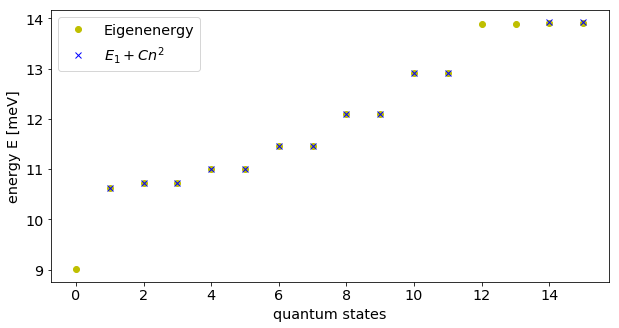

[ 9.00278814 10.63063313 10.72199497 10.72199497 10.99423657 10.99777139
 11.45239823 11.45239823 12.09073579 12.09075803 12.91046731 12.91046731
 13.89641304 13.89641304 13.91079635 13.91081432]
[10.630633133169416, 10.721994971687744, 10.721994971687744, 10.996080487242727, 10.996080487242727, 11.452889679834366, 11.452889679834366, 12.09242254946266, 12.09242254946266, 12.914679096127609, 12.914679096127609, 13.919659319829213, 13.919659319829213]


In [60]:
fig=pyplot.figure(figsize=(10,5))
pyplot.plot(L, evals, 'yo',label='Eigenenergy')
pyplot.xlabel("quantum states")
pyplot.ylabel("energy E [meV]")


test=[]
L_test=[0,1,1,2,2,3,3,4,4,5,5,6,6]
LL=[1,2,3,4,5,6,7,8,9,10,11,14,15]
C=(evals[2]-evals[1])
for n in L_test:
    test.append(evals[1]+C*n*n) #E+C*n^2 plus dodatkowy stan 11 jako stan w środku kropki

pyplot.plot(LL, test, 'bx',label=r'$E_1+Cn^2$')
pyplot.legend()
pyplot.show()
fig.savefig('../plot/E.eps')
print(evals)
print(test)

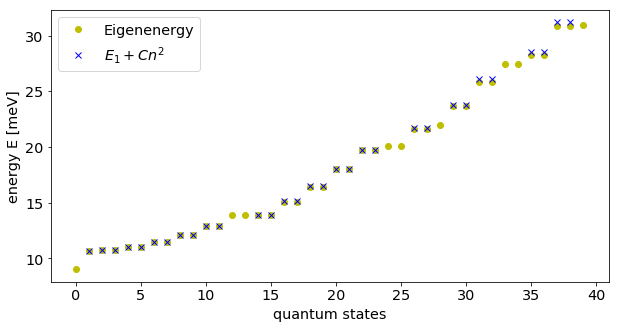

[ 9.00278814 10.63063313 10.72199497 10.72199497 10.99423657 10.99777139
 11.45239823 11.45239823 12.09073579 12.09075803 12.91046731 12.91046731
 13.89641304 13.89641304 13.91079635 13.91081432]
[10.630633133169416, 10.721994971687744, 10.721994971687744, 10.996080487242727, 10.996080487242727, 11.452889679834366, 11.452889679834366, 12.09242254946266, 12.09242254946266, 12.914679096127609, 12.914679096127609, 13.919659319829213, 13.919659319829213, 15.107363220567473, 15.107363220567473, 16.47779079834239, 16.47779079834239, 18.030942053153957, 18.030942053153957, 19.766816985002187, 19.766816985002187, 21.685415593887065, 21.685415593887065, 23.786737879808605, 23.786737879808605, 26.070783842766794, 26.070783842766794, 28.537553482761645, 28.537553482761645, 31.187046799793144, 31.187046799793144]


In [59]:
fig=pyplot.figure(figsize=(10,5))
pyplot.plot(L_big, evals_big, 'yo',label='Eigenenergy')
pyplot.xlabel("quantum states")
pyplot.ylabel("energy E [meV]")


test=[]
L_test=[0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15,15]
LL=[1,2,3,4,5,6,7,8,9,10,11,14,15,16,17,18,19,20,21,22,23,26,27,29,30,31,32,35,36,37,38]
C=(evals[2]-evals[1])
for n in L_test:
    test.append(evals[1]+C*n*n) #E+C*n^2 plus dodatkowy stan 11 jako stan w środku kropki

pyplot.plot(LL, test, 'bx',label=r'$E_1+Cn^2$')
pyplot.legend()
pyplot.show()
fig.savefig('../plot/E_big.eps')
print(evals)
print(test)

In [52]:
print(evecs[0])
print(len(evecs))
print(len(sys.sites()))
print(len(evecs[0])) #each evecs contain 15 eigenstates in specific site
print(evals)

[ 1.39487546e-13-1.13442388e-14j -1.40786372e-05-3.73622074e-06j
  5.28174496e-06+1.30180326e-05j -2.72351609e-06-1.45592400e-05j
 -1.39410153e-05-1.42021880e-05j  3.48480679e-06-4.44563689e-06j
  1.24882977e-05+1.48938683e-05j -4.95951152e-06-6.80287124e-06j
 -1.10292517e-05-6.57882833e-07j -7.08456863e-06-1.64248453e-05j
  8.95389500e-06+1.64754232e-05j -6.71497122e-06-7.60663395e-06j
 -5.42054603e-14+2.92598862e-13j -3.02483634e-13+1.13252846e-13j
 -1.57683349e-05+2.46962912e-06j -1.85536737e-06-1.45015690e-05j
  1.19966267e-05+1.17032515e-05j  1.41870327e-05-2.29338899e-06j
 -2.00629009e-05-1.53043881e-06j -1.38877271e-06-1.00088512e-05j
 -1.51233015e-05-6.54716683e-07j  1.26572932e-05-1.17806645e-05j
  2.30244638e-05-3.13306117e-06j -1.46067152e-06+4.20007725e-06j
  6.16018736e-13+1.57443324e-13j  1.22761040e-13+1.41566279e-13j
 -1.10044176e-05+7.34978338e-06j -1.31841000e-05-1.31142577e-05j
  2.53585259e-14-7.34008835e-13j -1.58833498e-05-1.92973511e-05j
 -2.03566305e-06+8.051351

In [53]:
#for i in sysf.sites:
#    print(i.pos)

/home/michal/anaconda2/envs/acmin/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


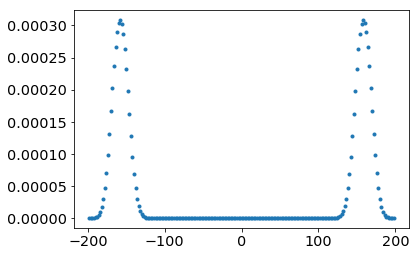

In [54]:
#create lists with site position and vector
Vec=[]
pos=[]
for n_i,i in enumerate(sysf.sites):
    Vec.append(evecs[n_i])
    pos.append(list(i.pos))
                   
        
LV=[]
Lx=[]
test=[]
test2=[]
for i in np.linspace(-200+a,200-a,400/a-1):
    LV.append(abs(Vec[pos.index([i,0])][4])**2)
    Lx.append(i)
    #print(Vec[pos.index([i,0])][4])
    #test.append(np.imag(Vec[pos.index([i,0])][3]))
    #test2.append(np.real(Vec[pos.index([i,0])][3]))

pyplot.plot(Lx,LV,'.')
#pyplot.plot(Lx,test,'.')
#pyplot.plot(Lx,test2,'.')

In [55]:
#print(Vec[3])
#print(len(Vec))
#print(len(pos))
#print(a)
#print(pos)

In [56]:
#a=1
#print(pos.index([a-1,0.0]))
E=[]
for i in range(16): #quantum state
    psipsi=[]
    psipsi2=[]
    psiHpsi=[]

    for n_v,v in enumerate(Vec): #petla po sitach
        psi=v[i]
        psi_conj=np.conj(psi)
        #print(psi*psi_conj)
        
        x,y = pos[n_v][0], pos[n_v][1]
        if not x**2+y**2 < (r_0-a):
            continue  

        
        dx2=(Vec[pos.index([x+a,y])][i] + Vec[pos.index([x-a,y])][i] - 2*Vec[pos.index([x,y])][i]) / (a*a)
        dy2=(Vec[pos.index([x,y+a])][i] + Vec[pos.index([x,y-a])][i] - 2*Vec[pos.index([x,y])][i]) / (a*a)
        da=a*a
        Hpsi=-dy2-dx2+V(x,y,0.1)*psi
        psiHpsi.append(da*psi_conj*Hpsi)
        
        psipsi.append(da*abs(psi)**2)
    
    E.append(sum(psiHpsi)/sum(psipsi))
    
    


#print(sum(psipsi))
    

In [61]:
print(sum(psipsi))
#print(da*psi_conj*Hpsi)

3.2618232694898322e-22


In [62]:
print(np.real(E))
E_real=np.real(E)
E_im=np.imag(E)
print(evals)



[0.10145808 0.10217374 0.10221398 0.10221398 0.10233371 0.10233526
 0.10253511 0.10253513 0.10281636 0.10281566 0.1031761  0.10317611
 0.10360956 0.10360956 0.10361587 0.10361583]
[ 9.00278814 10.63063313 10.72199497 10.72199497 10.99423657 10.99777139
 11.45239823 11.45239823 12.09073579 12.09075803 12.91046731 12.91046731
 13.89641304 13.89641304 13.91079635 13.91081432]


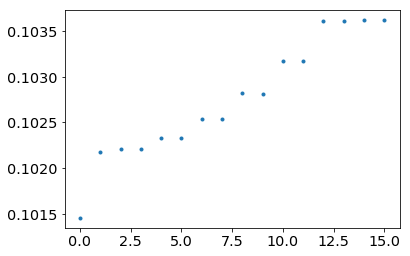

In [63]:
pyplot.plot(range(len(E_real)),E_real,'.')

In [64]:
#pyplot.plot(range(len(E_im)),E_im,'.')

In [90]:
#a=1
#print(pos.index([a-1,0.0]))
m=[]
for i in range(16): #quantum state
    psipsi=[]
    psiLpsi=[]
    for n_v,v in enumerate(Vec): #petla po sitach
        psi=v[i]
        psi_conj=np.conj(psi)
        #print(psi*psi_conj)
        
        x,y = pos[n_v][0], pos[n_v][1]
        if not x**2+y**2 < (r_0-a):
            continue  
    
        dx=(Vec[pos.index([x+a,y])][i] - Vec[pos.index([x-a,y])][i]) / (2*a)
        dy=(Vec[pos.index([x,y+a])][i] - Vec[pos.index([x,y-a])][i]) / (2*a)
        Lpsi=-1j*(x*dy-y*dx)
        
        da=a*a*a_unit*a_unit
        
        psiLpsi.append(da*psi_conj*Lpsi)
        #print(psi_conj*psi)
        #print(da)
        psipsi.append(da*abs(psi)**2)
    
    m.append(sum(psiLpsi)/sum(psipsi))  
    

#print(sum(psipsi)) 

In [91]:

print(np.real(m))
m_real=np.real(m)
m_im=np.imag(m)
#-3.061309730893737e-08, -5.092010621692428e-09, -1.2862127498164313e-12, -1.4711525412378018e-14, -2.5531784238663217e-17, 2.4519036499359942e-11, 1.3093064566850582e-10, 3.390161861948965e-08,

[ 2.42197502e-18  1.23716541e-10  2.19215726e-01 -2.30108662e-01
  9.15663028e-08 -1.21774519e-07  3.72008206e-02 -4.30613621e-02
  3.89165783e-06 -3.93546999e-10  8.33356976e-01 -8.36043514e-01
  8.89284410e-01 -8.86792090e-01  4.19091051e-04  1.10247194e-04]


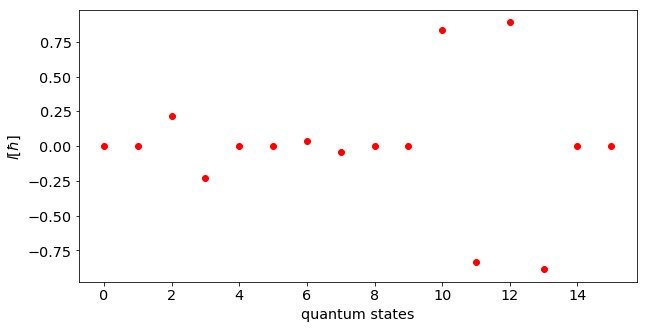

In [97]:

fig=pyplot.figure(figsize=(10,5))
pyplot.plot(range(len(m_real)),m_real,'ro')
pyplot.xlabel("quantum states")
pyplot.ylabel(r'$l [\hbar]$')


pyplot.show()
fig.savefig('../plot/l.eps')

In [70]:
#a=1
#print(pos.index([a-1,0.0]))
l=[]
for i in range(16): #quantum state
    psipsi=[]
    psiL2psi=[]
    for n_v,v in enumerate(Vec): #petla po sitach
        psi=v[i]
        psi_conj=np.conj(psi)
        #print(psi*psi_conj)
        
        x,y = pos[n_v][0], pos[n_v][1]
        if not x**2+y**2 < (r_0-a):
            continue  
    
        dx=(Vec[pos.index([x+a,y])][i] - Vec[pos.index([x-a,y])][i]) / (2*a)
        dy=(Vec[pos.index([x,y+a])][i] - Vec[pos.index([x,y-a])][i]) / (2*a)
        dx2=(Vec[pos.index([x+a,y])][i] + Vec[pos.index([x-a,y])][i] - 2*Vec[pos.index([x,y])][i]) / (a*a)
        dy2=(Vec[pos.index([x,y+a])][i] + Vec[pos.index([x,y-a])][i] - 2*Vec[pos.index([x,y])][i]) / (a*a)
        dy_a=(Vec[pos.index([x+a,y+a])][i] - Vec[pos.index([x+a,y-a])][i]) / (2*a)
        dy_b=(Vec[pos.index([x-a,y+a])][i] - Vec[pos.index([x-a,y-a])][i]) / (2*a)
        dxdy=(dy_a-dy_b) / (2*a)
        L2psi=-(x*x*dy2-x*dx-x*y*dxdy - y*dy - y*x*dxdy + y*y*dx2)
        
        da=a*a
        
        psiL2psi.append(da*psi_conj*L2psi)
        #print(psi_conj*psi)
        #print(da)
        psipsi.append(da*abs(psi)**2)
    
    l.append(sum(psiL2psi)/sum(psipsi))
    
    
    

#print(sum(psipsi))
    

In [71]:
print(sum(psipsi))

3.2618232694898322e-22


In [72]:


print(np.real(l))
l_real=np.real(l)
l_im=np.imag(l)
#-3.061309730893737e-08, -5.092010621692428e-09, -1.2862127498164313e-12, -1.4711525412378018e-14, -2.5531784238663217e-17, 2.4519036499359942e-11, 1.3093064566850582e-10, 3.390161861948965e-08,

[ 2.47637278e-05  5.01794955e-05  9.99043214e-01  9.99043152e-01
  3.99539005e+00  3.99548714e+00  1.82414493e+00  1.82414519e+00
  1.59775606e+01 -2.98602816e-03  1.00028816e+00  1.00028877e+00
  9.98396832e-01  9.98396832e-01  4.00292243e+00  4.00262731e+00]


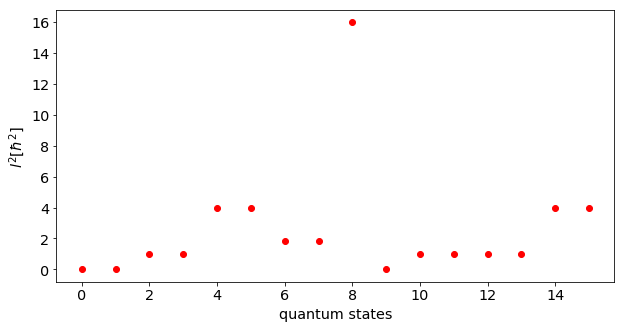

In [98]:
fig=pyplot.figure(figsize=(10,5))
pyplot.plot(range(len(l_real)),l_real,'ro')
pyplot.xlabel("quantum states")
pyplot.ylabel(r'$l^2 [\hbar^2]$')


pyplot.show()
fig.savefig('../plot/l2.eps')


In [74]:
#attempts to separate wave functions to pure states

import copy
#seperate wave functions
sp_Vec=[]
for i in Vec:
    sp_Vec.append(copy.deepcopy(i))

for n_i,i in enumerate(Vec):
    sp_Vec[n_i][2]=0.5*(Vec[n_i][2]-Vec[n_i][3])
    sp_Vec[n_i][3]=0.5*(Vec[n_i][2]+Vec[n_i][3])
    sp_Vec[n_i][4]=0.5*(Vec[n_i][4]-Vec[n_i][5])
    sp_Vec[n_i][5]=0.5*(Vec[n_i][4]+Vec[n_i][5])
    sp_Vec[n_i][6]=0.5*(Vec[n_i][6]-Vec[n_i][7])
    sp_Vec[n_i][7]=0.5*(Vec[n_i][6]+Vec[n_i][7])
    sp_Vec[n_i][8]=0.5*(Vec[n_i][8]-Vec[n_i][9])
    sp_Vec[n_i][9]=0.5*(Vec[n_i][8]+Vec[n_i][9])
    sp_Vec[n_i][10]=0.5*(Vec[n_i][10]-Vec[n_i][11])
    sp_Vec[n_i][11]=0.5*(Vec[n_i][10]+Vec[n_i][11])
    sp_Vec[n_i][12]=0.5*(Vec[n_i][12]-Vec[n_i][13])
    sp_Vec[n_i][13]=0.5*(Vec[n_i][12]+Vec[n_i][13])
    sp_Vec[n_i][14]=0.5*(Vec[n_i][14]-Vec[n_i][15])
    sp_Vec[n_i][15]=0.5*(Vec[n_i][14]+Vec[n_i][15])
    
print(sp_Vec[0])
print(Vec[0])


[ 1.39487546e-13-1.13442388e-14j -1.40786372e-05-3.73622074e-06j
  4.00263053e-06+1.37886363e-05j  1.27911443e-06-7.70603742e-07j
 -8.71291104e-06-4.87827557e-06j -5.22810424e-06-9.32391246e-06j
  8.72390462e-06+1.08483697e-05j  3.76439309e-06+4.04549851e-06j
 -1.97234151e-06+7.88348124e-06j -9.05691015e-06-8.54136408e-06j
  7.83443311e-06+1.20410286e-05j  1.11946189e-06+4.43439461e-06j
  1.24139087e-13+8.96730078e-14j -1.78344547e-13+2.02925854e-13j
 -6.95648379e-06+8.48559904e-06j -8.81185116e-06-6.01596991e-06j
  1.19966267e-05+1.17032515e-05j  1.41870327e-05-2.29338899e-06j
 -2.00629009e-05-1.53043881e-06j -1.38877271e-06-1.00088512e-05j
 -1.51233015e-05-6.54716683e-07j  1.26572932e-05-1.17806645e-05j
  2.30244638e-05-3.13306117e-06j -1.46067152e-06+4.20007725e-06j
  6.16018736e-13+1.57443324e-13j  1.22761040e-13+1.41566279e-13j
 -1.10044176e-05+7.34978338e-06j -1.31841000e-05-1.31142577e-05j
  2.53585259e-14-7.34008835e-13j -1.58833498e-05-1.92973511e-05j
 -2.03566305e-06+8.051351

In [75]:
#a=1
#print(pos.index([a-1,0.0]))
m_sep=[]
for i in range(16): #quantum state
    psipsi=[]
    psiLpsi=[]
    for n_v,v in enumerate(sp_Vec): #petla po sitach
        psi=v[i]
        psi_conj=np.conj(psi)
        #print(psi*psi_conj)
        
        x,y = pos[n_v][0], pos[n_v][1]
        if not x**2+y**2 < (r_0-a):
            continue  
    
        dx=(sp_Vec[pos.index([x+a,y])][i] - sp_Vec[pos.index([x-a,y])][i]) / (2*a)
        dy=(sp_Vec[pos.index([x,y+a])][i] - sp_Vec[pos.index([x,y-a])][i]) / (2*a)
        Lpsi=-1j*(x*dy-y*dx)
        
        da=a*a
        
        psiLpsi.append(da*psi_conj*Lpsi)
        #print(psi_conj*psi)
        #print(da)
        psipsi.append(da*abs(psi)**2)
    
    m_sep.append(sum(psiLpsi)/sum(psipsi))
    
    
    

#print(sum(psipsi))

In [76]:
print(np.real(m_sep))
m_sep_real=np.real(m_sep)
m_sep_im=np.imag(m_sep)

[ 2.42197500e-18  1.23716541e-10  1.99169126e-01 -2.00977695e-01
 -1.97534232e+00  1.97534211e+00 -3.94078470e-03 -1.80570988e-03
  9.09450747e-04 -9.09449305e-04 -5.31867644e-01  5.27753932e-01
 -4.23869544e-01  4.23415742e-01  1.99299965e+00 -1.99172812e+00]


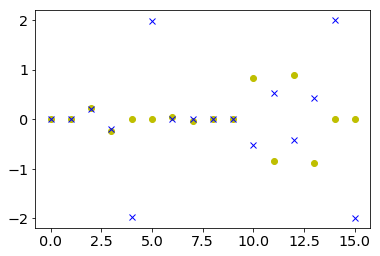

In [77]:
pyplot.plot(range(len(m_real)),m_real,'oy')
pyplot.plot(range(len(m_sep_real)),m_sep_real,'xb')

In [78]:
#a=1
#print(pos.index([a-1,0.0]))
l_sep=[]
for i in range(16): #quantum state
    psipsi=[]
    psiL2psi=[]
    for n_v,v in enumerate(sp_Vec): #petla po sitach
        psi=v[i]
        psi_conj=np.conj(psi)
        #print(psi*psi_conj)
        
        x,y = pos[n_v][0], pos[n_v][1]
        if not x**2+y**2 < (r_0-a):
            continue  
    
        dx=(sp_Vec[pos.index([x+a,y])][i] - sp_Vec[pos.index([x-a,y])][i]) / (2*a)
        dy=(sp_Vec[pos.index([x,y+a])][i] - sp_Vec[pos.index([x,y-a])][i]) / (2*a)
        dx2=(sp_Vec[pos.index([x+a,y])][i] + sp_Vec[pos.index([x-a,y])][i] - 2*sp_Vec[pos.index([x,y])][i]) / (a*a)
        dy2=(sp_Vec[pos.index([x,y+a])][i] + sp_Vec[pos.index([x,y-a])][i] - 2*sp_Vec[pos.index([x,y])][i]) / (a*a)
        dy_a=(sp_Vec[pos.index([x+a,y+a])][i] - sp_Vec[pos.index([x+a,y-a])][i]) / (2*a)
        dy_b=(sp_Vec[pos.index([x-a,y+a])][i] - sp_Vec[pos.index([x-a,y-a])][i]) / (2*a)
        dxdy=(dy_a-dy_b) / (2*a)
        L2psi=-(x*x*dy2-x*dx-x*y*dxdy - y*dy - y*x*dxdy + y*y*dx2)
        
        da=a*a
        
        psiL2psi.append(da*psi_conj*L2psi)
        #print(psi_conj*psi)
        #print(da)
        psipsi.append(da*abs(psi)**2)
    
    l_sep.append(sum(psiL2psi)/sum(psipsi))
    
    
    

#print(sum(psipsi))
    

In [79]:
print(sum(psipsi))

1.568521689406594e-22


In [80]:


print(np.real(l_sep))
l_sep_real=np.real(l_sep)
l_sep_im=np.imag(l_sep)
#-3.061309730893737e-08, -5.092010621692428e-09, -1.2862127498164313e-12, -1.4711525412378018e-14, -2.5531784238663217e-17, 2.4519036499359942e-11, 1.3093064566850582e-10, 3.390161861948965e-08,

[ 2.47637278e-05  5.01794955e-05  9.99043181e-01  9.99043184e-01
  3.99543424e+00  3.99543530e+00  1.82415055e+00  1.82413895e+00
 -1.46623479e-03 -1.46606512e-03  1.00028823e+00  1.00028870e+00
  9.98396832e-01  9.98396832e-01  4.00337759e+00  4.00216059e+00]


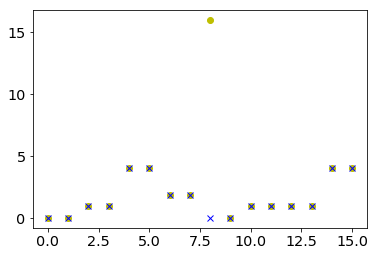

In [81]:
pyplot.plot(range(len(l_real)),l_real,'oy')
pyplot.plot(range(len(l_sep_real)),l_sep_real,'xb')

[0.004976316686902305, 0.004976316686902305, 0.007083748690344977, 0.007083748690344977, 0.9995214923764547, 0.9995214923764547, 0.9995214612610468, 0.9995214612610468, 1.998847180286721, 1.998847180286721, 1.998871467695596, 1.998871467695596, 1.3506090956274428, 1.3506090956274428, 1.3506091922749859, 1.3506091922749859, 3.9971940919601976, 3.9971940919601976, 0.05464456203059423, 0.05464456203059423, 1.0001440676301447, 1.0001440676301447, 1.0001443766365476, 1.0001443766365476, 0.9991980943956554, 0.9991980943956554, 0.9991980943956544, 0.9991980943956544, 2.000730475336526, 2.000730475336526, 2.0006567186899047, 2.0006567186899047]


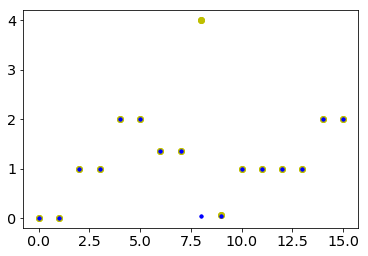

In [82]:
ll=[]
lsp=[]
nn=[]
for n,i in enumerate(l_real):
    ll.append(math.sqrt(abs(i)))
    ll.append(math.sqrt(abs(i)))
    lsp.append(math.sqrt(abs(l_sep_real[n])))
    lsp.append(math.sqrt(abs(l_sep_real[n])))
    nn.append(n)
    nn.append(n)
    
pyplot.plot(nn,ll,'oy')
pyplot.plot(nn,lsp,'.b')
print(ll)